****
# Introduction #
****
**This Notebooks goal is to Correctly classify Human Emoiton based on the images present**

**If you found this Notebook helpful or if you liked this notebook kindly Upvote :)**

****
# Dataset Description and Goal #
****

**About the Dataset**


* The data consists of 48x48 pixel grayscale images of faces.
* The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.


**Goal**

* The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
* The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

****
# Loading the Directories #
****

In [ ]:
# Loading the directories

train=r'/kaggle/input/fer2013/train'
test=r'/kaggle/input/fer2013/test'

****
# Reading and Preprocessing Data from Directories ##
****

In [ ]:
# importing

import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_size=(48,48)
bth_size=32

# Augmenting Images for training set

trdatagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.1
)

# Only Rescaling or Normalizing the pixel values for testing Set
tedatagen = ImageDataGenerator(rescale=1.0/255)


In [ ]:
# Reading the training data from directory

traingen= trdatagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    subset='training')

# Reading the testing data from Directory

testgen = tedatagen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# Validation data which is a subset taken from the training data (10% of the training data)
valgen = trdatagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 25841 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 2868 images belonging to 7 classes.


****
# Displaying Training and Testing Images #
****

In [ ]:
# importing
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

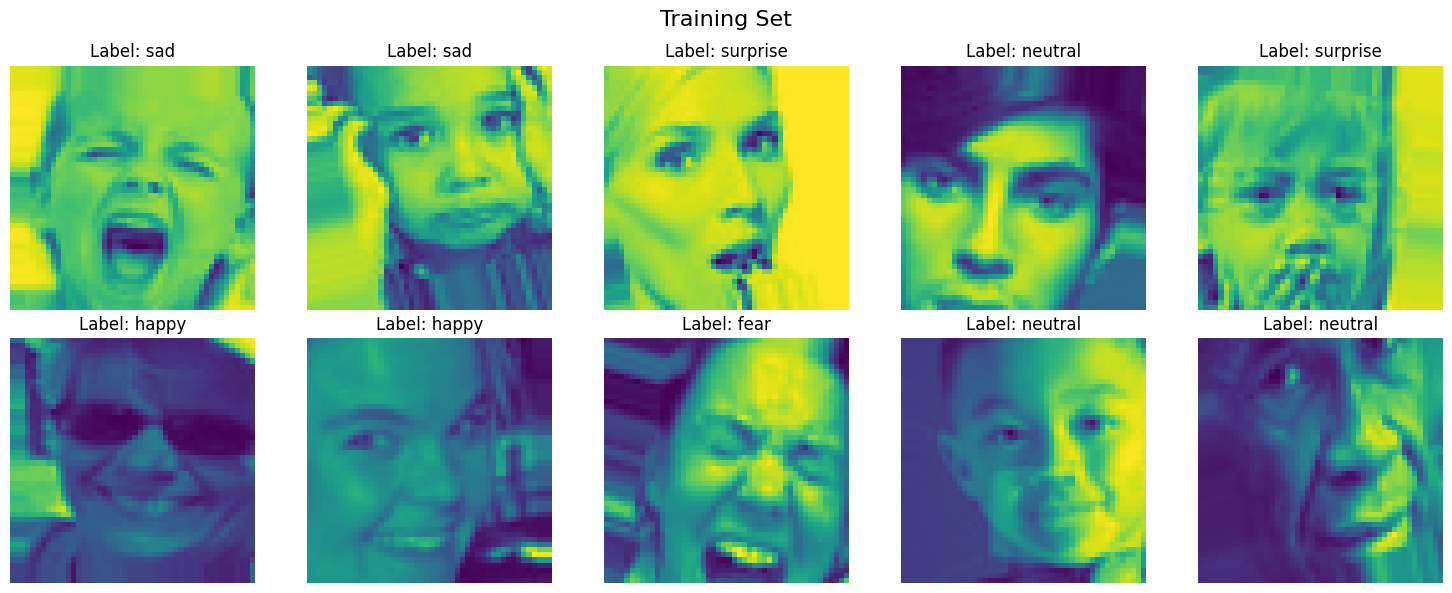

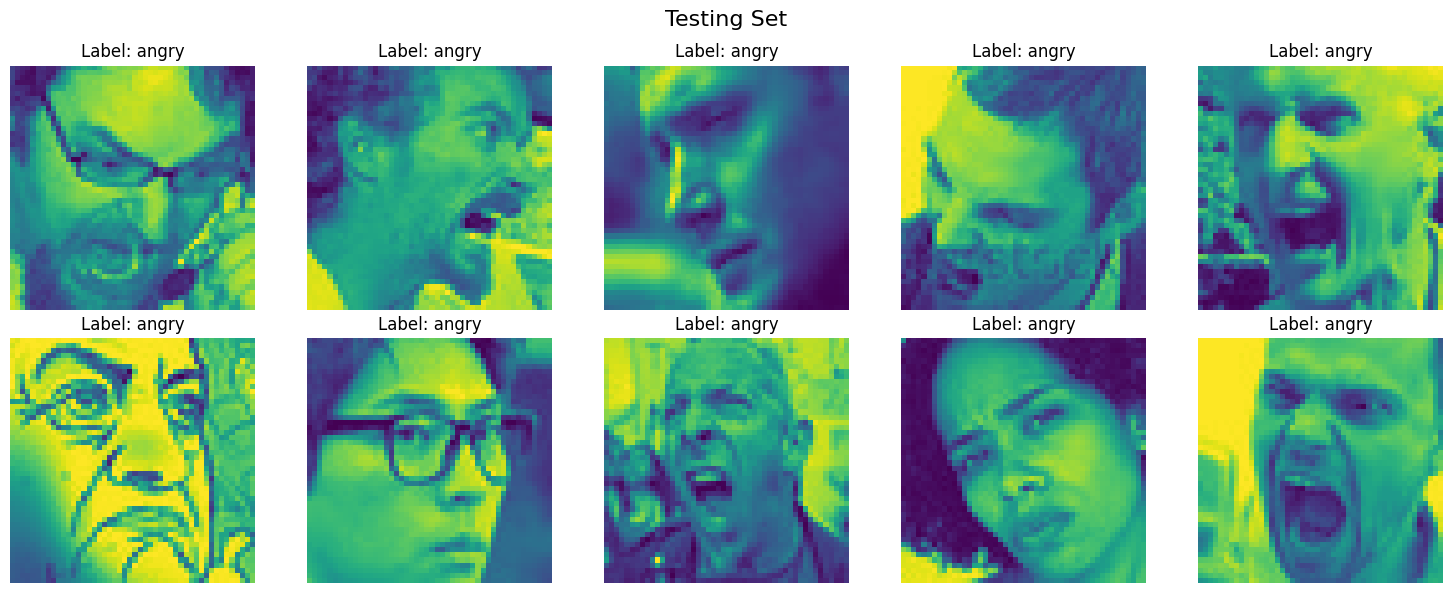

In [ ]:
# Displaying the training and testing datsets
# Only 10 Images from each set

def plot_images_from_generator(generator, title, num_images=10, images_per_row=5):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {list(generator.class_indices.keys())[label.argmax()]}")

    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_from_generator(traingen, "Training Set", num_images=10, images_per_row=5)
plot_images_from_generator(testgen, "Testing Set", num_images=10, images_per_row=5)

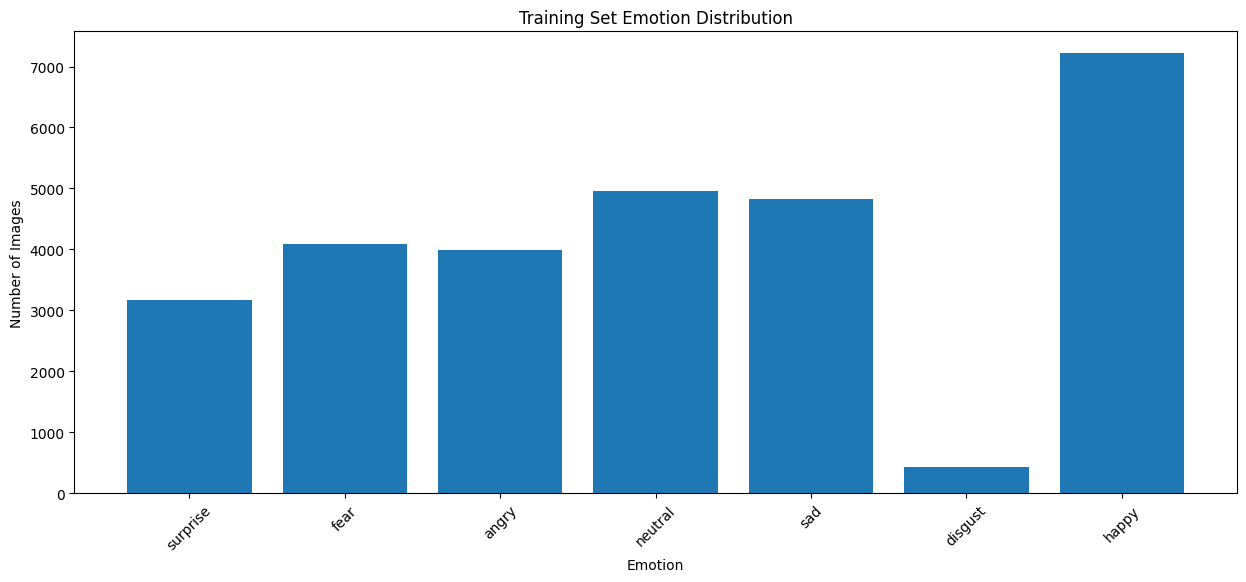

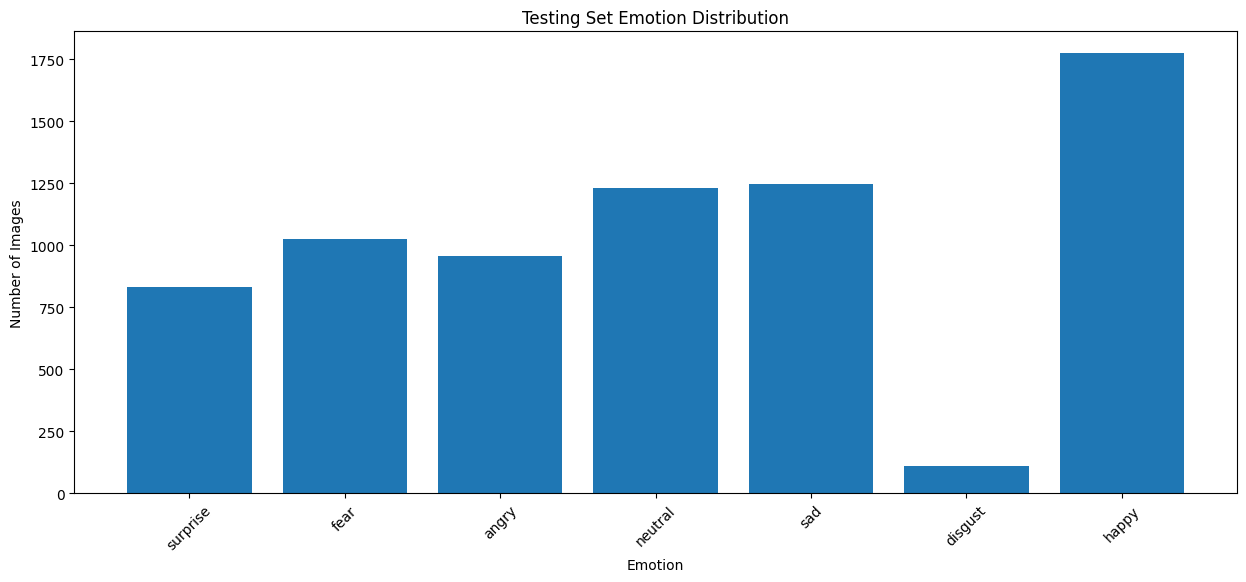

In [ ]:
#class distribution

def plot_class_distribution(directory, title):
    class_names = os.listdir(directory)
    class_counts = []
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts.append(len(os.listdir(class_dir)))

    plt.figure(figsize=(15, 6))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train, "Training Set Emotion Distribution")
plot_class_distribution(test, "Testing Set Emotion Distribution")

In [ ]:
# Label Map
label_map = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral'
}

****
# CNN  Model #
****

In [ ]:
# importing

import keras as k
from keras.models import Sequential
from keras.layers import Conv2D,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:

model = Sequential()

# CNN Layer 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48, 48, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# CNN Layer 2
model.add(Conv2D(128, (5,5), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# CNN Layer 3
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CNN Layer 4
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CNN Layer 5
model.add(Conv2D(1024, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Global Average Pooling layer is used instead of Flatten as it is more effiecient
#Note: There is feature loss when we use GAP
model.add(GlobalAveragePooling2D())

#Dense Layer 1
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer 2
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer 3
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Output Layer
model.add(Dense(7, activation='softmax'))

#Adam Optimizer
opt = k.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,598,983 (36.62 MB)

 Trainable params: 9,590,919 (36.59 MB)

 Non-trainable params: 8,064 (31.50 KB)

In [ ]:
#Implementing Early Stopping and Learning Rate Reduction
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [ ]:
history = model.fit(
    traingen,
    epochs=70,
    validation_data=valgen,
    callbacks=callbacks_list
)

Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


808/808 ━━━━━━━━━━━━━━━━━━━━ 186s 212ms/step - accuracy: 0.1804 - loss: 2.4936 - val_accuracy: 0.2364 - val_loss: 2.1793 - learning_rate: 0.0010
Epoch 2/70
808/808 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.2398 - loss: 1.8521 - val_accuracy: 0.2374 - val_loss: 1.8280 - learning_rate: 0.0010
Epoch 3/70
808/808 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.2834 - loss: 1.7480 - val_accuracy: 0.2877 - val_loss: 1.7718 - learning_rate: 0.0010
Epoch 4/70
808/808 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.3803 - loss: 1.5860 - val_accuracy: 0.4135 - val_loss: 1.4973 - learning_rate: 0.0010
Epoch 5/70
808/808 ━━━━━━━━━━━━━━━━━━━━ 81s 100ms/step - accuracy: 0.4264 - loss: 1.4810 - val_accuracy: 0.4414 - val_loss: 1.4694 - learning_rate: 0.0010
Epoch 6/70
808/808 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.4567 - loss: 1.4207 - val_accuracy: 0.4791 - val_loss: 1.3667 - learning_rate: 0.0010
Epoch 7/70
808/808 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.4587 - loss: 1.3

In [ ]:
#Predicting
test_loss, test_accuracy = model.evaluate(testgen)

225/225 ━━━━━━━━━━━━━━━━━━━━ 96s 428ms/step - accuracy: 0.6247 - loss: 1.0283


In [ ]:
# === SAVE CENTRALIZED MODEL BEFORE FEDERATED LEARNING ===
CENTRALIZED_MODEL_PATH = "/kaggle/working/centralized_model.weights.h5"  # Updated extension
model.save_weights(CENTRALIZED_MODEL_PATH)
print(f"[Centralized Model Saved] at {CENTRALIZED_MODEL_PATH}")

[Centralized Model Saved] at /kaggle/working/centralized_model.weights.h5


In [ ]:
# # === LOAD CENTRALIZED MODEL BEFORE FEDERATED LEARNING ===
# CENTRALIZED_MODEL_PATH = "/kaggle/working/centralized_model.weights.h5"
# model.load_weights(CENTRALIZED_MODEL_PATH)
# print(f"[Centralized Model Loaded] from {CENTRALIZED_MODEL_PATH}")

****
# Evaluation Metrics #
****

In [ ]:
# importing
from sklearn.metrics import classification_report, confusion_matrix

Test Accuracy: 0.67
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       958
           1       0.77      0.52      0.62       111
           2       0.59      0.39      0.47      1024
           3       0.86      0.88      0.87      1774
           4       0.54      0.76      0.63      1233
           5       0.59      0.48      0.53      1247
           6       0.75      0.82      0.78       831

    accuracy                           0.67      7178
   macro avg       0.67      0.63      0.64      7178
weighted avg       0.67      0.67      0.66      7178

Confusion Matrix:
[[ 571    7   52   41  168   92   27]
 [  31   58    2    4    7    6    3]
 [ 133    6  396   44  161  170  114]
 [  24    0   21 1564  106   25   34]
 [  50    2   38   80  932  105   26]
 [ 118    2  103   52  351  599   22]
 [  25    0   55   43   15   14  679]] 




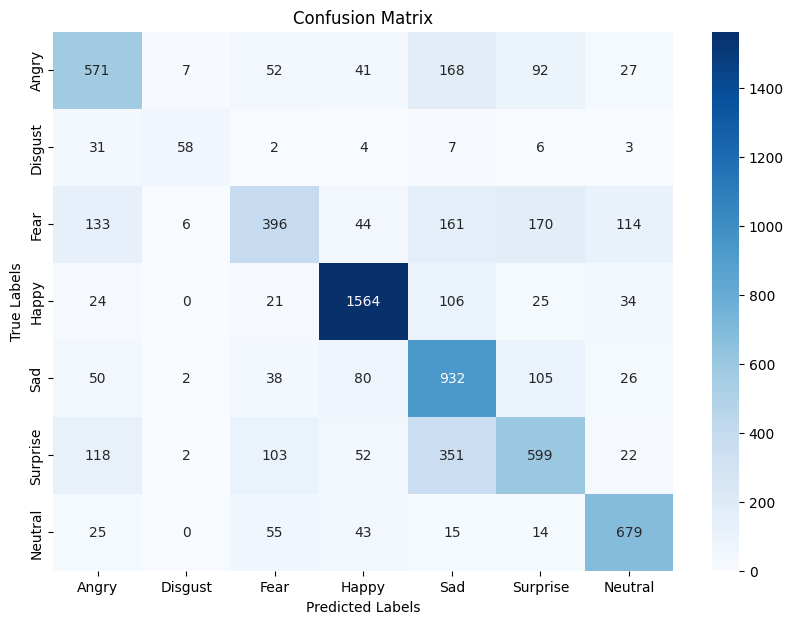

Training class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
print(f"Test Accuracy: {test_accuracy:.2f}")
y_pred = np.argmax(model.predict(testgen), axis=1)
y_true = testgen.classes
print("Classification Report:")
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix,'\n\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Training class indices:", traingen.class_indices)
print("Test class indices:", testgen.class_indices)


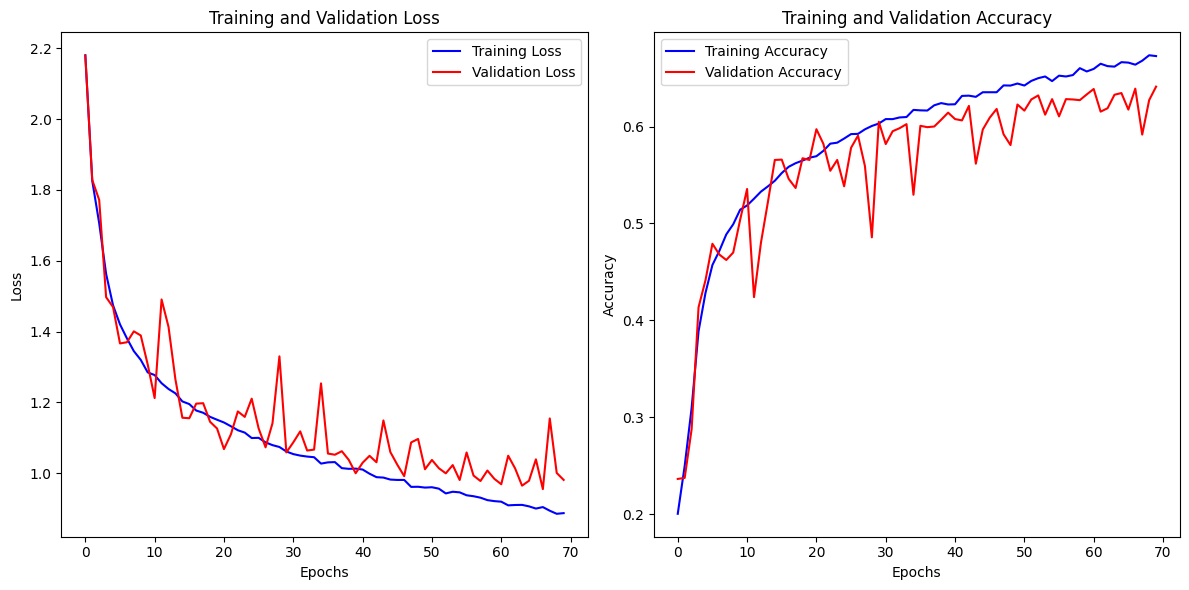

In [ ]:
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step


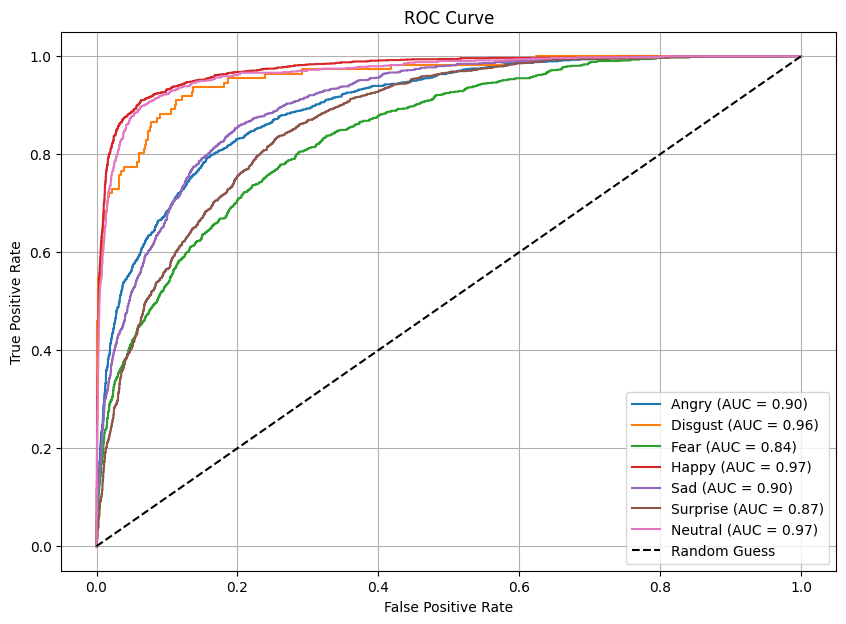

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert true labels to one-hot encoding for ROC calculations
y_true_onehot = label_binarize(y_true, classes=[0, 1, 2, 3, 4,5,6])
y_pred_prob = model.predict(testgen)

plt.figure(figsize=(10, 7))

# Plot ROC for each class
for i, class_name in label_map.items():
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

---
## FedAvg

---

In [5]:
import time
import psutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
import os
from sklearn.model_selection import train_test_split

def print_system_stats():
    """Print system resource utilization"""
    gpu_stats = tf.config.list_physical_devices('GPU')
    mem = psutil.virtual_memory()
    print(f"\nSystem Resources - GPUs: {len(gpu_stats)} | "
          f"CPU Usage: {psutil.cpu_percent()}% | "
          f"RAM Usage: {mem.used/1e9:.1f}/{mem.total/1e9:.1f} GB")

def prepare_client_data(traingen, num_clients=10, batches_per_client=10):
    """Prepares client data by loading all batches into memory"""
    client_data = {}

    # Get all training indices
    filenames = traingen.filenames
    labels = traingen.classes

    # Stratified split for clients
    client_indices = {}
    for label in np.unique(labels):
        label_indices = np.where(labels == label)[0]
        splits = np.array_split(label_indices, num_clients)
        for i, split in enumerate(splits):
            if f"client_{i}" not in client_indices:
                client_indices[f"client_{i}"] = []
            client_indices[f"client_{i}"].extend(split)

    # Create client datasets
    for client_id in client_indices:
        batches = []
        indices = client_indices[client_id]
        np.random.shuffle(indices)

        # Create batches
        for i in range(0, len(indices), traingen.batch_size):
            batch_indices = indices[i:i+traingen.batch_size]
            X_batch, y_batch = [], []
            for idx in batch_indices:
                img, label = traingen._get_batches_of_transformed_samples([idx])
                X_batch.append(img[0])
                y_batch.append(label[0])

            if len(X_batch) > 0:
                batches.append((np.array(X_batch), np.array(y_batch)))
                if len(batches) >= batches_per_client:
                    break

        client_data[client_id] = batches

    return client_data

def run_fedavg_with_progress(traingen, testgen, rounds=20, local_epochs=5):
    """Run Federated Averaging with configurable local epochs"""
    # Initialize training
    start_time = time.time()
    model = load_model("/kaggle/input/centralised-model/keras/default/1/centralized_model.h5")
    best_acc = 0

    # Prepare client data
    print("Preparing client data...")
    client_data = prepare_client_data(traingen, num_clients=10, batches_per_client=10)

    # Training header
    print("\nStarting Federated Training")
    print(f"Configuration - Clients: {len(client_data)} | "
          f"Total Rounds: {rounds} | "
          f"Local Epochs: {local_epochs} | "
          f"Batch Size: {traingen.batch_size}")
    print_system_stats()

    for round_num in range(1, rounds + 1):
        round_start = time.time()
        client_weights = []

        print(f"\nROUND {round_num}/{rounds}")
        print("="*50)

        # Client training phase
        for client_id, batches in client_data.items():
            local_model = clone_model(model)
            local_model.set_weights(model.get_weights())
            local_model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            # Train for multiple local epochs
            for epoch in range(local_epochs):
                np.random.shuffle(batches)  # Shuffle between epochs
                for X_batch, y_batch in batches:
                    loss, acc = local_model.train_on_batch(X_batch, y_batch)

            client_weights.append(local_model.get_weights())
            print(f"Client {client_id} trained on {len(batches)} batches × {local_epochs} epochs")

        # Weight aggregation (FedAvg)
        avg_weights = [
            np.mean([client_weights[i][j] for i in range(len(client_weights))], axis=0)
            for j in range(len(client_weights[0]))
        ]
        model.set_weights(avg_weights)

        # Validation
        X_val, y_val = [], []
        for i, (X_batch, y_batch) in enumerate(testgen):
            if i >= 100 // testgen.batch_size:
                break
            X_val.append(X_batch)
            y_val.append(y_batch)
        X_val = np.concatenate(X_val)
        y_val = np.concatenate(y_val)

        test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
        if test_acc > best_acc:
            best_acc = test_acc
            model.save("/kaggle/working/fedavg_best.h5")
            print(f"New best model saved with accuracy: {best_acc:.4f}")

        # Save checkpoint
        round_path = f"/kaggle/working/fedavg_round_{round_num}.h5"
        model.save(round_path)
        print(f"\nRound {round_num} checkpoint saved to: {round_path}")
        print(f"Test Accuracy: {test_acc:.4f} (Best: {best_acc:.4f})")
        print(f"Round time: {time.time() - round_start:.1f}s")
        print_system_stats()

    # Final saves
    final_path = "/kaggle/working/fedavg_final.h5"
    model.save(final_path)
    total_time = (time.time() - start_time)/60
    print(f"\nTraining Complete - Total Time: {total_time:.1f} minutes")
    print(f"Best Accuracy Achieved: {best_acc:.4f}")
    print(f"Final model saved to: {final_path}")

    return model

# Verify data generators exist
if 'traingen' not in globals() or 'testgen' not in globals():
    raise RuntimeError("Data generators not found. Initialize traingen and testgen first.")

# Start training
print("\nInitializing Federated Training...")
fedavg_model = run_fedavg_with_progress(
    traingen=traingen,
    testgen=testgen,
    rounds=20,
    local_epochs=5  # Each client trains for 5 epochs per round
)

print("\nTraining completed successfully!")
print("Saved models:")
print(f"- Best model: /kaggle/working/fedavg_best.h5")
print(f"- Final model: /kaggle/working/fedavg_final.h5")
print(f"- Round checkpoints: /kaggle/working/fedavg_round_*.h5")

Starting Federated Training with 10 clients, 20 rounds, 5 local epochs
System Resources - GPUs: 1 | CPU Usage: 38% | RAM Usage: 12.4/15.6 GB


ROUND 1/20
Client client_0 trained on 10 batches × 5 epochs
Client client_1 trained on 10 batches × 5 epochs
Client client_2 trained on 10 batches × 5 epochs
Client client_3 trained on 10 batches × 5 epochs
Client client_4 trained on 10 batches × 5 epochs
Client client_5 trained on 10 batches × 5 epochs
Client client_6 trained on 10 batches × 5 epochs
Client client_7 trained on 10 batches × 5 epochs
Client client_8 trained on 10 batches × 5 epochs
Client client_9 trained on 10 batches × 5 epochs

Round 1 checkpoint saved to: /kaggle/working/fedavg_round_1.h5
Test Accuracy: 0.6196 (Best: 0.6246)
Round time: 53.8s
System Resources - GPUs: 1 | CPU Usage: 35% | RAM Usage: 12.3/15.6 GB

ROUND 2/20
Client client_0 trained on 10 batches × 5 epochs
Client client_1 trained on 10 batches × 5 epochs
Client client_2 trained on 10 batches × 5 epochs
Client c

In [7]:
print(f"Test Accuracy: {test_accuracy:.2f}")
y_pred = np.argmax(model.predict(testgen), axis=1)
y_true = testgen.classes
print("Classification Report:")
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix,'\n\n')

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       958
           1       0.79      0.55      0.65       111
           2       0.62      0.42      0.50      1024
           3       0.88      0.90      0.89      1774
           4       0.57      0.79      0.66      1233
           5       0.62      0.51      0.56      1247
           6       0.78      0.84      0.81       831

    accuracy                           0.71      7178
   macro avg       0.70      0.66      0.67      7178
weighted avg       0.70      0.71      0.70      7178

Confusion Matrix:
[[ 603    6   48   38  152   85   26]
 [  29   61    2    3    8    5    3]
 [ 125    5  430   40  148  155  121]
 [  22    0   18 1597   98   20   19]
 [  45    1   35   75  974   88   15]
 [ 110    1   98   45  338  636   19]
 [  21    0   48   39   13   12  698]]


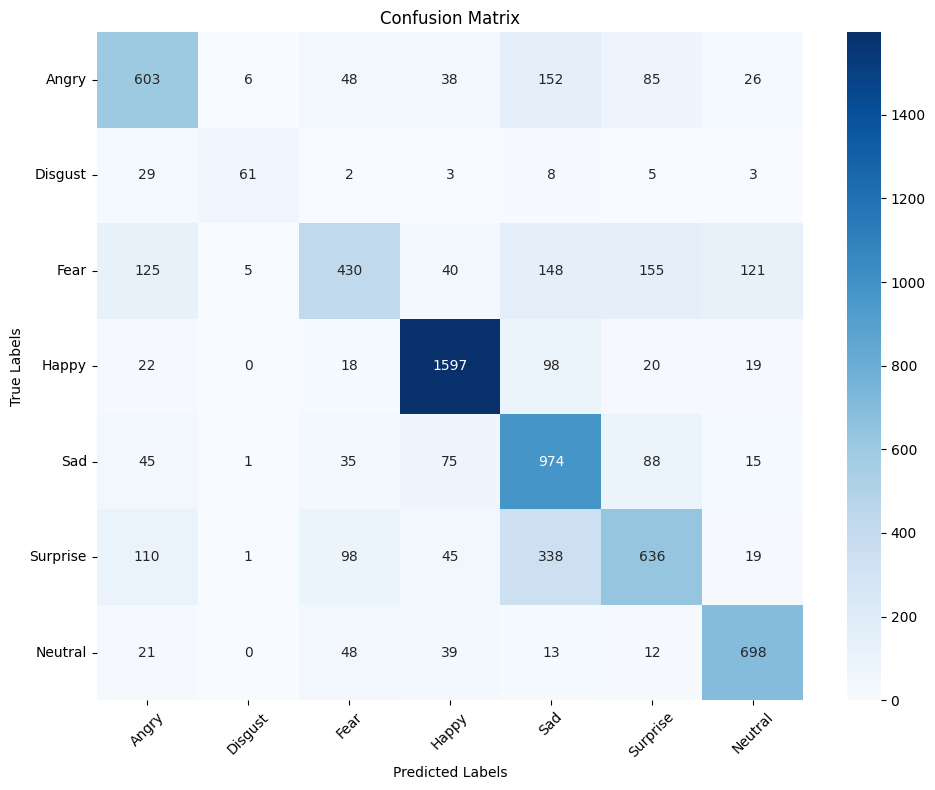

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the confusion matrix
confusion_matrix = np.array([
    [603, 6, 48, 38, 152, 85, 26],
    [29, 61, 2, 3, 8, 5, 3],
    [125, 5, 430, 40, 148, 155, 121],
    [22, 0, 18, 1597, 98, 20, 19],
    [45, 1, 35, 75, 974, 88, 15],
    [110, 1, 98, 45, 338, 636, 19],
    [21, 0, 48, 39, 13, 12, 698]
])

# Class labels
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                 xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
